<a href="https://colab.research.google.com/github/vbanai/Supervised_Learning_Projects/blob/main/Airbnb_rental_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This data set is from Kaggle and contains almost 50 thousand airbnb listings in NYC. The purpose of this task is to predict the price of NYC Airbnb rentals based on the data provided. </br>
</br>
The reason why I chose this dataset for prediction purposes is that I considered it to be quite tough to reach good results by using traditional data analyst methods. I saw on the Kaggle competition page that the best models reached only 0,5 R2 scored. I was intrested in if I can achieve better results. 


In [ ]:
import os
!pip install shap
import shap

os.environ['KAGGLE_USERNAME'] = "viktorbanai" # username from the json file
os.environ['KAGGLE_KEY'] = "9431db56af1a1a63cab88b4e516a2248" # key from the json file
!kaggle datasets download -d dgomonov/new-york-city-airbnb-open-data # api copied from kaggle

!mkdir file_destination_booking
!unzip -u "/content/new-york-city-airbnb-open-data.zip" -d "/content/file_destination_airbnb"

import pandas as pd
df_initial = pd.read_csv("/content/file_destination_airbnb/AB_NYC_2019.csv")
df_initial.head()

Exploring the dataset

In [4]:
df_initial.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [ ]:
df_initial.shape

(48895, 16)

In [5]:
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [6]:
df_initial.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Convert the date to datetime

In [4]:
df_initial['last_review']=pd.to_datetime(df_initial['last_review'])

Check which are the chategorical values

In [11]:
cat_values=df_initial.select_dtypes(include=[object])
cat_values

,name,host_name,neighbourhood_group,neighbourhood,room_type
0,Clean & quiet apt home by the park,John,Brooklyn,Kensington,Private room
1,Skylit Midtown Castle,Jennifer,Manhattan,Midtown,Entire home/apt
2,THE VILLAGE OF HARLEM....NEW YORK !,Elisabeth,Manhattan,Harlem,Private room
3,Cozy Entire Floor of Brownstone,LisaRoxanne,Brooklyn,Clinton Hill,Entire home/apt
4,Entire Apt: Spacious Studio/Loft by central park,Laura,Manhattan,East Harlem,Entire home/apt
...,...,...,...,...,...
48890,Charming one bedroom - newly renovated rowhouse,Sabrina,Brooklyn,Bedford-Stuyvesant,Private room
48891,Affordable room in Bushwick/East Williamsburg,Marisol,Brooklyn,Bushwick,Private room
48892,Sunny Studio at Historical Neighborhood,Ilgar & Aysel,Manhattan,Harlem,Entire home/apt
48893,43rd St. Time Square-cozy single bed,Taz,Manhattan,Hell's Kitchen,Shared room


Drop some columns which I consider not having too much relevance (I will retain id and host_id)

In [47]:
df_fortrans=df_initial.copy(deep=True)
df_fortrans.drop(["name", "host_name", "last_review"], axis=1, inplace=True)

In [48]:
df_fortrans.isnull().sum()

id                                    0
host_id                               0
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Fill the reviews_per_month columns' NA slots with mean values

In [49]:
import numpy as np
mean=np.mean(df_fortrans["reviews_per_month"])
mean 

1.3732214298586884

In [50]:
df_fortrans["reviews_per_month"]=df_fortrans["reviews_per_month"].fillna(np.mean(df_fortrans["reviews_per_month"]))

Check the correlation matrix of the numeric columns

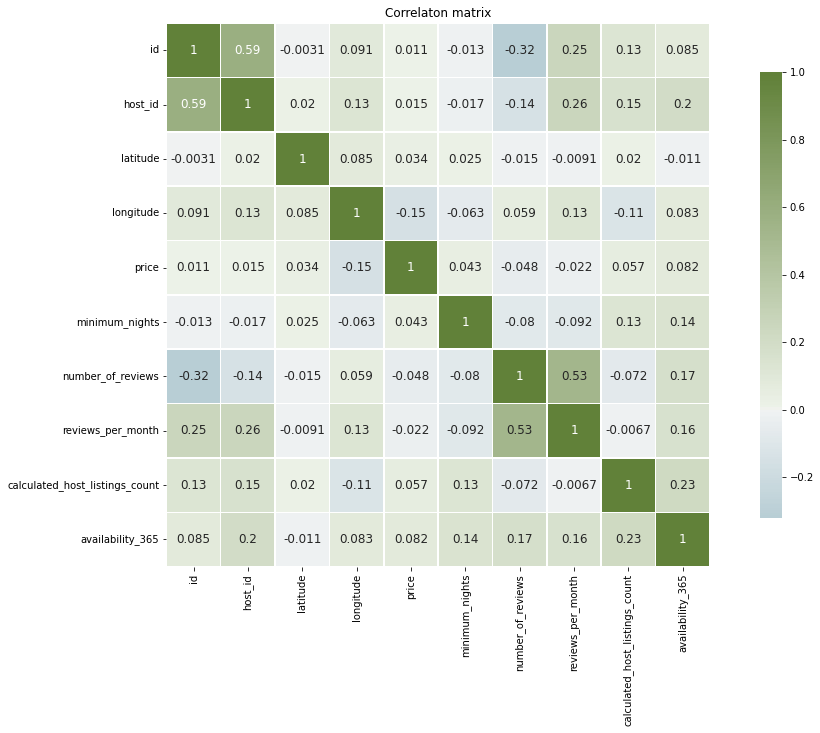

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

corrmat=df_fortrans.corr()
plt.subplots(figsize=(18,10))
cmap=sns.diverging_palette(220,110, as_cmap=True)
sns.heatmap(corrmat, annot=True, cmap=cmap, annot_kws={'size':12}, vmax=1, center=0, square=True, linewidths=0.5, cbar_kws={'shrink':0.82})
plt.title("Correlaton matrix")
plt.savefig("Correlaton matrix")
plt.show()

Check the correlation values using the correlation matrix

In [19]:
corrmat['price'].sort_values(ascending=False)

price                             1.000000
availability_365                  0.081829
calculated_host_listings_count    0.057472
minimum_nights                    0.042799
latitude                          0.033939
host_id                           0.015309
id                                0.010619
reviews_per_month                -0.022373
number_of_reviews                -0.047954
longitude                        -0.150019
Name: price, dtype: float64

In [20]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

df_fortrans.select_dtypes(include=numerics).columns.to_list()

['id',
 'host_id',
 'latitude',
 'longitude',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']

Check the predictive power of independent variables by SHAP

 Ranking of the features by predicting power according to SHAP values



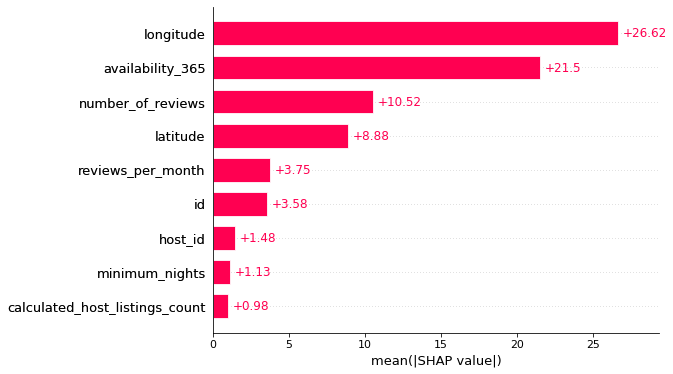

In [22]:

from sklearn.linear_model import LinearRegression
shap.initjs()

dataframe_original_ = df_fortrans

cols_independent=['id',
 'host_id',
 'latitude',
 'longitude',
 
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']

print(" Ranking of the features by predicting power according to SHAP values\n")
X=dataframe_original_[cols_independent]
y=dataframe_original_['price']
model=LinearRegression().fit(X,y)
explainer=shap.Explainer(model, X)
shap_values=explainer(X)

shap.plots.bar(shap_values, max_display=14)

Check the data by Neighbourhood Groups

Text(0.5, 1.0, 'Neighbourhood Group')

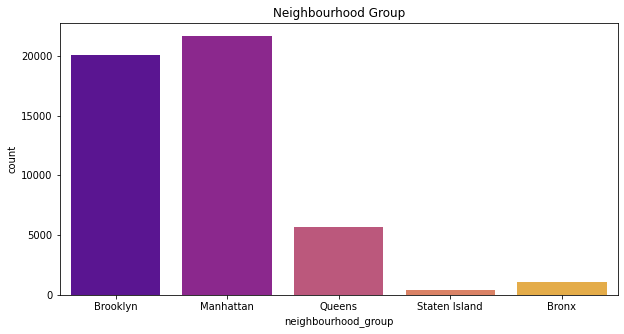

In [38]:
plt.figure(figsize=(10,5))
sns.countplot(data=df_fortrans, x='neighbourhood_group', palette="plasma")
plt.title('Neighbourhood Group')

Check the values in the 'price' column

In [4]:
print("How many numeric values can be found in the PRICE column? ", df_initial['price'].astype(str).str.isnumeric().sum())
print("How many alpha characters can be found in the PRICE column? ", df_initial['price'].astype(str).str.isalpha().sum())
print("Do we have negative value in the PRICE column? " , df_initial.loc[df_initial['price']<0])

How many numeric values can be found in the PRICE column?  48895
How many alpha characters can be found in the PRICE column?  0
Do we have negative value in the PRICE column?  Empty DataFrame
Columns: [id, name, host_id, host_name, neighbourhood_group, neighbourhood, latitude, longitude, room_type, price, minimum_nights, number_of_reviews, last_review, reviews_per_month, calculated_host_listings_count, availability_365]
Index: []


Check the skewness and the outlier values of the "price" column

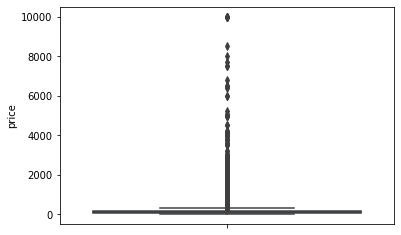

In [7]:
#We can see a few high value prices, the majority of the data is close to the bottom

import seaborn as sns

sns.boxplot(y=df_fortrans['price'])

In [10]:
#Check the skewness  (0 is when data dataset distribution is perfectly symetric)

df_fortrans['price'].skew()

19.118938995046033

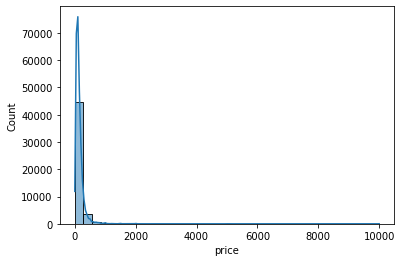

In [8]:
sns.histplot(df_fortrans['price'], bins=35, kde=True)


In [ ]:
#AS WE GOT  THAT THE DATASET IS SKEWED, THERE IS NO NEED TO CALCULATE KURTOSIS, BUT JUST FOR FUN I DO IT
#Kurtosis  (normal distribution has Kurtosis rate 3 - mesokurtic) (Platokurtic if less then 3)
# According to the value 586 the distribution would be LEPTOKURTIC (the rate is higher than 3 with pronunced center region and long tails)

df_fortrans['price'].kurtosis()



585.6728788988286

Remove some outlier values from the "price" column

In [5]:
#This is an alternative outlier removal technic , I used the second one with percentile in this assigment (anyway both give almost the same result)
#1) Dropping the outlier rows with STANDARD DEVIATION
factor = 3
upper_lim = df_fortrans['price'].mean () + df_fortrans['price'].std () * factor
lower_lim = df_fortrans['price'].mean () - df_fortrans['price'].std () * factor

df_fortrans = df_fortrans[(df_fortrans['price'] < upper_lim) & (df_fortrans['price'] > lower_lim)]

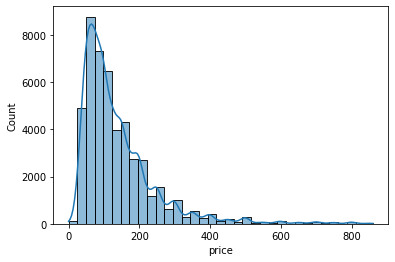

In [7]:
import seaborn as sns
sns.histplot(df_fortrans['price'], bins=35, kde=True)

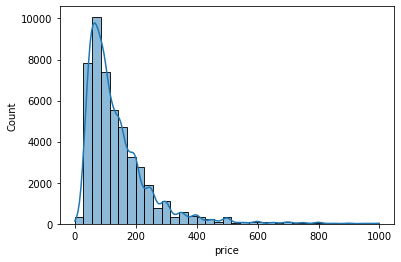

In [51]:
#2) Let's treat the high value price data as outliers and remove it with PERCENTILE.
import seaborn as sns
df_fortrans=df_fortrans[df_fortrans["price"]<df_fortrans["price"].quantile(0.995)].reset_index(drop=True)
#df_fortrans=df_fortrans[df_fortrans["price"]<df_fortrans["price"].quantile(0.05)].reset_index(drop=True)


# Check the skewness now after the outlier removal

sns.histplot(df_fortrans['price'], bins=35, kde=True)

Check the price by the neighbourhood groups

In [23]:

df_fortrans.groupby('neighbourhood_group')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
neighbourhood_group,,,,,,,,
Bronx,1089.0,84.443526,72.689400,0.0,45.0,65.0,99.0,800.0
Brooklyn,20037.0,117.235564,91.722395,0.0,60.0,90.0,150.0,999.0
Manhattan,21448.0,177.366747,129.114887,0.0,95.0,149.0,219.0,999.0
Queens,5653.0,94.528038,71.570674,10.0,50.0,75.0,110.0,900.0
Staten Island,370.0,96.148649,84.022175,13.0,50.0,75.0,109.0,800.0


In [24]:
df_fortrans.pivot_table(index='neighbourhood_group',columns='room_type',values='price',aggfunc='mean')

room_type,Entire home/apt,Private room,Shared room
neighbourhood_group,,,
Bronx,125.198413,63.050691,59.800000
Brooklyn,167.628746,72.566400,50.527845
Manhattan,222.463891,108.998240,87.075157
Queens,141.172414,68.244214,49.312821
Staten Island,134.953757,62.292553,57.444444


In [ ]:
df_fortrans.groupby(['neighbourhood_group', 'room_type'])['price'].mean()

Check the price by Latitude and Longitude data

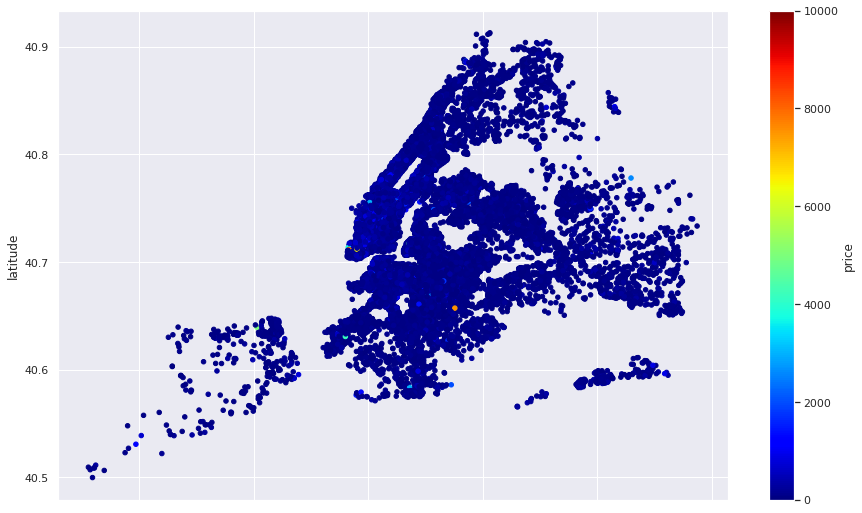

In [57]:
df_fortrans.plot(kind="scatter", x="longitude", y="latitude", figsize=(15,9), c="price", cmap=plt.get_cmap("jet"), colorbar=True)

Check the neighbourhood groups (we can see that the highest price is in Brooklyn)

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


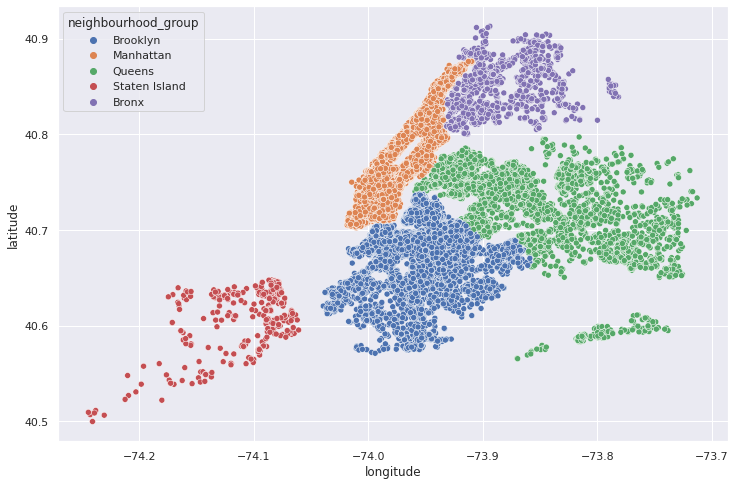

In [59]:
plt_dims=(12,8)
plt.figure(figsize=plt_dims)
sns.scatterplot(df_fortrans.longitude, df_fortrans.latitude, hue=df_fortrans.neighbourhood_group)
#plt.ioff()


Check the popularity of the Neighbourhoods (neighbourhood has high power on the price)

Text(0.5, 1.0, '20 most popular neighbourhoods')

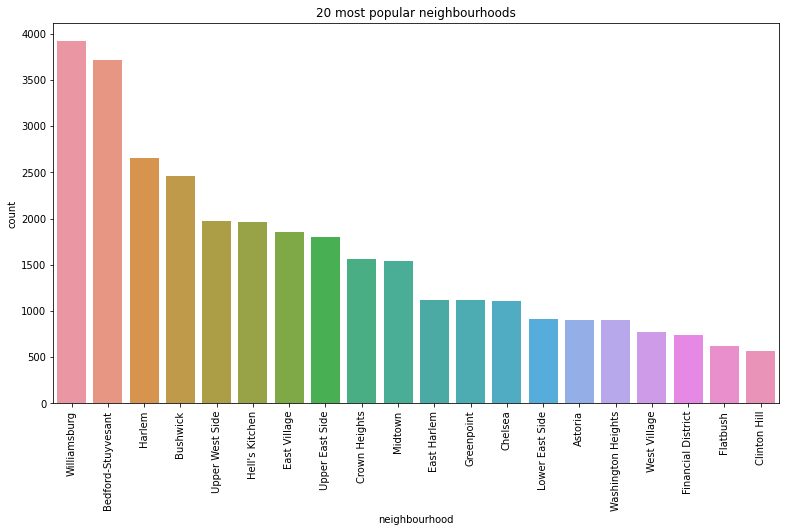

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
list_of_top20_neighbourhood=list(df_fortrans["neighbourhood"].value_counts().head(20).index)
df_fortrans_top20neighbourhood=df_fortrans[df_fortrans["neighbourhood"].isin(list_of_top20_neighbourhood)].reset_index(drop=True)

plt.figure(figsize=(13,7))
sns.countplot(x="neighbourhood", data=df_fortrans, order=df_fortrans["neighbourhood"].value_counts().head(20).index)
plt.xticks(rotation=90)
plt.title("20 most popular neighbourhoods")

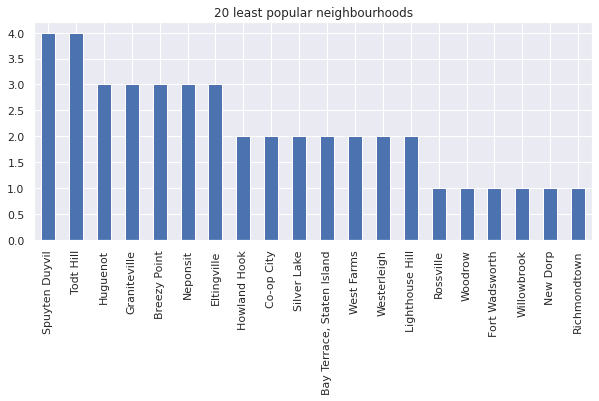

In [43]:
sns.set()
df_fortrans["neighbourhood"].value_counts().tail(20).plot(kind="bar", figsize=(10,4), title="20 least popular neighbourhoods")

PREDICTION </br>
</br>
First I predicted with traditional methods including using one hot encoding,  sklearn LR model, Polinomial model, RandomForrest method, etc. but I could reach only 0.44 R2Score with the best setup. I have saved the result with linear regression model with stratified shuffle split, where the R2Score is 0.36</br>
</br>
The one hot encoding technic caused the bad correlation score.  "Neighbourhood" column, which has very high correlation with pricing, has 221 unique values, and converting them to dummy variables is not the best method, because the dataset will be sparesed in this way with lot of "0" values, and it prevents the model to fit optimally.</br>
</br>
So I try to use leading-edge technic creating EMBEDDING for categorical variable "Neighbourhood' using a deep learning network on top of keras. Neighborhood is typically the most important feature in this prediction.</br>
</br>
Finally I experimented with FEATURE CROSSES for longitude and latitude values.This feature crosses technic doesn't work here and it performs the worst.

1) Using traditional prediction model with StratifiedShuffleSplit, I skipped normalizing as I checked it but didn't imporve the prediction

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()

df_fortrans["neighbourhood"+"_code"]=le.fit_transform(df_fortrans["neighbourhood"])

df_fortrans=pd.get_dummies(df_fortrans, drop_first=True)

lr=LinearRegression()
scores_l=[]
split=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df_fortrans, df_fortrans["neighbourhood_code"]):
  #del df_fortrans["neighbourhood_code"]
  strat_train_set=df_fortrans.loc[train_index]
  strat_train_set.drop("neighbourhood_code", axis=1, inplace=True)
  strat_test_set=df_fortrans.loc[test_index]
  strat_test_set.drop("neighbourhood_code", axis=1, inplace=True)
  y_train=strat_train_set.price
  X_train=strat_train_set.drop(["price"], axis=1)
  y_test=strat_test_set.price
  X_test=strat_test_set.drop(["price"], axis=1)
  lr.fit(X_train, y_train)
  X_test['prediction']=lr.predict(X_test)

  mae_SKLEARN=mean_absolute_error(y_test, X_test['prediction'])
  mse_SKLEARN=mean_squared_error(y_test, X_test['prediction'])
  r2score_SKLEARN=r2_score(y_test, X_test['prediction'])

  counter=0
  X_test=pd.concat([X_test, y_test], axis=1)
  X_test_list=X_test[['price', 'prediction']].values.tolist()
  for i in X_test_list:
    if i[0]>0.8*i[1] and i[0]<1.2*i[1]:
      counter+=1


  scores_l.append([mae_SKLEARN, mse_SKLEARN, r2score_SKLEARN, counter/len(X_test_list), train_index, test_index])

In [19]:
scores_l=pd.DataFrame(scores_l, columns=('Mean absolute error using SKLEARN', 'Mean squared error using SKLEARN', 'R2 score using SKLEARN', 'Prediction accuracy within -+20% range (with SKLEARN)', 'Opt.train index', 'Opt. test index' ))

In [20]:
scores_l

,Mean absolute error using SKLEARN,Mean squared error using SKLEARN,R2 score using SKLEARN,Prediction accuracy within -+20% range (with SKLEARN),Opt.train index,Opt. test index
0,54.103007,7888.527016,0.374423,0.353162,"[15999, 5727, 11179, 4345, 9470, 25909, 3981, ...","[2329, 19100, 4806, 14280, 26863, 15049, 26040..."
1,54.694655,8429.294456,0.356620,0.352381,"[23923, 23426, 25066, 26572, 21216, 4804, 3070...","[31470, 10982, 31558, 31727, 20488, 6970, 6853..."
2,53.917488,7982.811927,0.369486,0.350664,"[8078, 3532, 15953, 21026, 16261, 18657, 12723...","[26638, 23612, 26804, 3076, 5588, 28058, 28054..."
3,54.119368,8166.522954,0.366360,0.356909,"[28349, 6899, 31768, 6093, 14209, 4967, 17941,...","[28613, 14999, 18506, 10351, 31871, 30646, 294..."
4,54.242751,7968.417643,0.366791,0.348634,"[23504, 4396, 31482, 11304, 31325, 23986, 3087...","[31738, 4948, 1715, 4391, 9852, 1977, 11489, 2..."
5,53.819314,8038.274180,0.367162,0.364403,"[15189, 5411, 13887, 25989, 20865, 14548, 4988...","[18207, 2303, 6063, 13191, 22084, 13148, 482, ..."
6,54.718564,8564.186936,0.362172,0.347229,"[8261, 9078, 28591, 30707, 10010, 27256, 17110...","[21931, 14372, 8046, 26723, 11618, 11221, 6480..."
7,53.721337,8080.290342,0.382133,0.348478,"[17161, 12532, 21810, 15390, 12967, 26693, 244...","[28768, 25453, 27480, 5662, 13091, 31858, 1420..."
8,54.086354,7936.258101,0.351821,0.356596,"[2735, 25728, 4598, 26271, 10199, 20335, 9321,...","[1834, 13539, 7767, 2541, 19691, 1709, 13718, ..."
9,53.944304,8126.839019,0.376404,0.363310,"[26295, 5910, 18368, 2198, 2979, 5347, 11237, ...","[11565, 11728, 6291, 22787, 21242, 11968, 1666..."


Best result: Mean Absolute Error - 54, Mean Squarred Error - 8038, R2score - 0.38, Accuracy with +/- 20% range - 36%

2) Embedding

In [14]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

df_fortrans["neighbourhood"+"_code"]=le.fit_transform(df_fortrans["neighbourhood"])

In [8]:
df_fortrans["neighbourhood_group"]=pd.factorize(df_fortrans.neighbourhood_group)[0]
df_fortrans["neighbourhood"]=pd.factorize(df_fortrans.neighbourhood)[0]
df_fortrans["room_type"]=pd.factorize(df_fortrans.room_type)[0]

In [9]:
#scaling price data

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_fortrans['price_scaled'] = scaler.fit_transform(df_fortrans[['price']])
df_fortrans.head()

,id,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price_scaled
0,2539,2787,0,0,40.64749,-73.97237,0,149,1,9,0.21,6,365,0.149149
1,2595,2845,1,1,40.75362,-73.98377,1,225,1,45,0.38,2,355,0.225225
2,3647,4632,1,2,40.80902,-73.94190,0,150,3,0,NaN,1,365,0.150150
3,3831,4869,0,3,40.68514,-73.95976,1,89,1,270,4.64,1,194,0.089089
4,5022,7192,1,4,40.79851,-73.94399,1,80,10,9,0.10,1,0,0.080080


In [10]:
#Deep encoding


import tensorflow as tf
from keras.layers import Embedding, Dense, Flatten
import keras
from sklearn.preprocessing import MinMaxScaler
import keras
from keras import models

embedding_size = 4
model = models.Sequential()
model.add(Embedding(input_dim = 221, output_dim = embedding_size, input_length = 1, name="embedding"))
model.add(Flatten())
model.add(Dense(50, activation="relu"))
model.add(Dense(15, activation="relu"))
model.add(Dense(1))
model.compile(loss = "mse", optimizer = "adam", metrics=["accuracy"])
model.fit(x = df_fortrans['neighbourhood'].to_numpy(), y=df_fortrans['price_scaled'].to_numpy() , epochs = 50, batch_size = 4)

Epoch 1/50
12150/12150 [==============================] - 16s 1ms/step - loss: 0.0106 - accuracy: 2.2635e-04
Epoch 2/50
12150/12150 [==============================] - 15s 1ms/step - loss: 0.0103 - accuracy: 2.2635e-04
Epoch 3/50
12150/12150 [==============================] - 16s 1ms/step - loss: 0.0103 - accuracy: 2.2635e-04
Epoch 4/50
12150/12150 [==============================] - 15s 1ms/step - loss: 0.0103 - accuracy: 2.2635e-04
Epoch 5/50
12150/12150 [==============================] - 15s 1ms/step - loss: 0.0103 - accuracy: 2.2635e-04
Epoch 6/50
12150/12150 [==============================] - 15s 1ms/step - loss: 0.0103 - accuracy: 2.2635e-04
Epoch 7/50
12150/12150 [==============================] - 16s 1ms/step - loss: 0.0103 - accuracy: 2.2635e-04
Epoch 8/50
12150/12150 [==============================] - 16s 1ms/step - loss: 0.0103 - accuracy: 2.2635e-04
Epoch 9/50
12150/12150 [==============================] - 15s 1ms/step - loss: 0.0103 - accuracy: 2.2635e-04
Epoch 10/50
12150/1

In [11]:
layer = model.get_layer('embedding')
output_embeddings = layer.get_weights()


In [12]:
output_embeddings_df = pd.DataFrame(output_embeddings[0])
output_embeddings_df = output_embeddings_df.reset_index()
output_embeddings_df.columns = ['neighbourhood', 'embedding_1', 'embedding_2', 'embedding_3', 'embedding_4']
output_embeddings_df

,neighbourhood,embedding_1,embedding_2,embedding_3,embedding_4
0,0,-3.190721,3.732547,-2.791082,2.802863
1,1,0.343473,-0.014096,0.257037,0.258165
2,2,-1.656361,3.047272,2.428839,1.259295
3,3,-0.349773,1.636736,2.346528,2.694432
4,4,-0.738493,2.422797,3.083380,0.963881
...,...,...,...,...,...
216,216,-4.077024,4.681755,2.531972,4.101585
217,217,0.456259,1.059621,0.710563,1.318837
218,218,-0.439847,1.593143,-0.902382,1.444256
219,219,0.656780,0.628216,-0.535595,0.848904


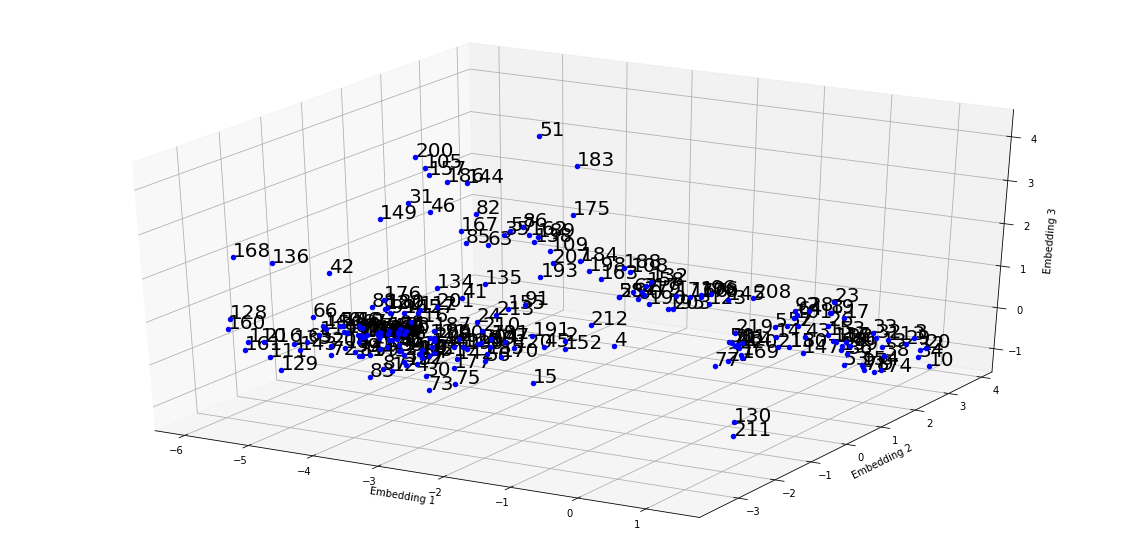

In [12]:
#Plot the first 3 embedings on a 3D plot in relation with the price to check if we can see
# a clear relationship between the price and the neighbourhoods. We can see that the neighbourhoods with similar price are grouped closer 

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

m = output_embeddings_df.iloc[:,1:].to_numpy()
labels = output_embeddings_df.iloc[:,0:1].to_numpy()
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')

for i in range(len(labels)):
    ax.scatter(m[i,0],m[i,1],m[i,2], color='b')
    ax.text(m[i,0],m[i,1],m[i,2],'%s'%(str(labels[i][0])), size=20, zorder=1, color='k')

ax.set_xlabel('Embedding 1')  
ax.set_ylabel('Embedding 2')  
ax.set_zlabel('Embedding 3')  
plt.show()

In [13]:
#merge the original dataset and the embedding df

merged_df = pd.merge(df_fortrans, output_embeddings_df, on="neighbourhood")
merged_df=merged_df.drop("neighbourhood", axis=1)

In [14]:
# determine the independent columns for test train split
merged_df_independent_cols=merged_df.copy(deep=True)
merged_df_independent_cols.drop("price", axis=1, inplace=True)
cols_independent=merged_df_independent_cols.columns.to_list()

In [17]:
# Check the r2score if I use an Sklearn Linear Regression model

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(merged_df[cols_independent], merged_df.price, test_size=0.2, random_state=0) 

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
linreg=LinearRegression()
linreg.fit(X_train, y_train)
y_pred=linreg.predict(X_test)
r2_score=r2_score(y_test, y_pred)
r2_score



1.0

In [18]:
# USING Random Forest model

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error



X_train, X_test, y_train, y_test=train_test_split(merged_df[cols_independent], merged_df.price, test_size=0.2, random_state=0) 




rf = RandomForestRegressor()
rf.fit(X_train, y_train)
X_test['prediction']=rf.predict(X_test)  



mae_SKLEARN=mean_absolute_error(y_test, X_test['prediction'])
mse_SKLEARN=mean_squared_error(y_test, X_test['prediction'])
r2score_SKLEARN=r2_score(y_test, X_test['prediction'])

counter=0
X_test=pd.concat([X_test, y_test], axis=1)
X_test_list=X_test[['price', 'prediction']].values.tolist()
for i in X_test_list:
  if i[0]>0.8*i[1] and i[0]<1.2*i[1]:
    counter+=1


print('Mean absolute error using SKLEARN: {:.2}'.format(mae_SKLEARN))
print('Mean squared error using SKLEARN: {:.2}'.format(mse_SKLEARN))
print('R2 score using SKLEARN: {:.2}'.format(r2score_SKLEARN))
print("Prediction accuracy within -+20% range (with SKLEARN): {:.2%}".format(counter/len(X_test_list)))


Mean absolute error using SKLEARN: 0.017
Mean squared error using SKLEARN: 0.075
R2 score using SKLEARN: 1.0
Prediction accuracy within -+20% range (with SKLEARN): 99.97%


3) FEATURE CROSSES for longitude and latitude 

In [62]:
# determine the independent columns for test train split
df_fortrans_independent_cols=df_fortrans.copy(deep=True)
df_fortrans_independent_cols.drop("price", axis=1, inplace=True)
cols_independent=df_fortrans_independent_cols.columns.to_list()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(df_fortrans[cols_independent], df_fortrans.price, test_size=0.2, random_state=0) 

In [97]:
from tensorflow.keras.layers import Dense, Dropout, DenseFeatures
import tensorflow as tf
from tensorflow import feature_column 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


resolution_in_degrees = 0.0001
# Create an empty list that will eventually hold all feature columns.
feature_columns = []

# Create a numerical feature column to represent latitude.
latitude = tf.feature_column.numeric_column("latitude")

latitude_boundaries = list(np.arange(min(df_fortrans['latitude']), 
                                     max(df_fortrans['latitude']), 
                                     resolution_in_degrees))
latitude = tf.feature_column.bucketized_column(latitude, 
                                               latitude_boundaries)


feature_columns.append(latitude)

# Create a numerical feature column to represent longitude.
longitude = tf.feature_column.numeric_column("longitude")

longitude_boundaries = list(np.arange(min(df_fortrans['longitude']), 
                                      max(df_fortrans['longitude']), 
                                      resolution_in_degrees))
longitude = tf.feature_column.bucketized_column(longitude, 
                                               longitude_boundaries)

feature_columns.append(longitude)

# Convert the list of feature columns into a layer that will ultimately become
# part of the model. Understanding layers is not important right now.
fp_feature_layer = layers.DenseFeatures(feature_columns)

In [ ]:
df_fortrans

Using buckets: It represents latitude and longitude in buckets (bins). Each bin represents normally all the neighborhoods within a single degree. For example, neighborhoods at latitude 40.4 and 40.6 are in the same bucket, but neighborhoods in latitude 40.4 and 41.5 are in different buckets. Here the problem is that NewYork situates almost within the same degrees, so this cross feature method may have some problems, but let's have a try.

In [ ]:
learning_rate = 0.05
epochs = 50
batch_size = 64
label_name = 'median_house_value'

model = tf.keras.models.Sequential()
model.add(fp_feature_layer)
model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

features = {name:np.array(value) for name, value in X_train.items()}
label = np.array(y_train)
history = model.fit(x=features, y=label, batch_size=batch_size,
                    epochs=epochs, shuffle=True)

In [99]:
hist = pd.DataFrame(history.history)
mse = hist["mean_squared_error"]

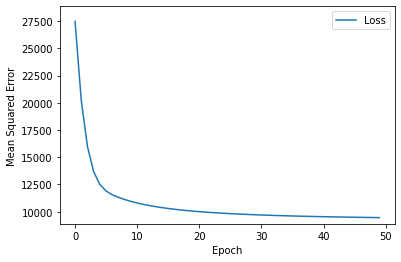

In [100]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")

plt.plot([x for x in range(epochs)], mse, label="Loss")
plt.legend()
plt.ylim([mse.min()*0.94, mse.max()* 1.05])
plt.show() 

In [ ]:
predictions=model({name:np.array(value) for name, value in X_test.items()})

In [102]:
predictions=predictions.numpy().tolist()
predictions_pd=pd.DataFrame(predictions)

In [105]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

mae_SKLEARN=mean_absolute_error(y_test, predictions_pd)
mse_SKLEARN=mean_squared_error(y_test, predictions_pd)
r2score_SKLEARN=r2_score(y_test, predictions_pd)

counter=0
for i, x in zip(predictions, y_test):
  if i[0]>0.8*x and i[0]<1.2*x:
    counter+=1


print('Mean absolute error: {:.2}'.format(mae_SKLEARN))
print('Mean squared error: {:.2}'.format(mse_SKLEARN))
print('R2 score: {:.2}'.format(r2score_SKLEARN))
print("Prediction accuracy within -+20% range: {:.2%}".format(counter/len(y_test)))

Mean absolute error: 7e+01
Mean squared error: 1.1e+04
R2 score: 0.14
Prediction accuracy within -+20% range: 24.06%


The feature crosses technic doesn't work here and it performs the worst, I am not sure but maybe because in this case we have relatively small territory and almost every geographical points fall in the same degree of latitude and longitude. The model learns a separate weight for each bucket.